In [1]:
from python_speech_features import mfcc, logfbank # for extracting audio features.
from scipy.io import wavfile # reads WAV audio files
import numpy as np
import matplotlib.pyplot as plt # for visualizations
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix # evalulation and plotting
import itertools
import os # navigating the file system of repo

# how to download the data (commented out for now)
# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
# print("Path to dataset files:", path)

In [2]:
# reading and processing a single audio file
sampling_freq, audio = wavfile.read("genres/blues/blues.00000.wav") # reads a .wav file
mfcc_features = mfcc(audio, sampling_freq) # computes hte mfcc and filter bank features
filterbank_features = logfbank(audio, sampling_freq)

In [3]:
# outputs how many feature frames (windows) there are and the length of each
print ('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])
print ('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print ('Length of each feature =', filterbank_features.shape[1])


MFCC:
Number of windows = 2994
Length of each feature = 13

Filter bank:
Number of windows = 2994
Length of each feature = 26


10
genres/blues/blues.00093.wav 2994
genres/classical/classical.00079.wav 2994
genres/jazz/jazz.00016.wav 2994
genres/country/country.00088.wav 2994
genres/pop/pop.00027.wav 2992
genres/rock/rock.00011.wav 2994
genres/metal/metal.00022.wav 2992
genres/disco/disco.00052.wav 2992
genres/hiphop/hiphop.00022.wav 2994
genres/reggae/reggae.00080.wav 2992


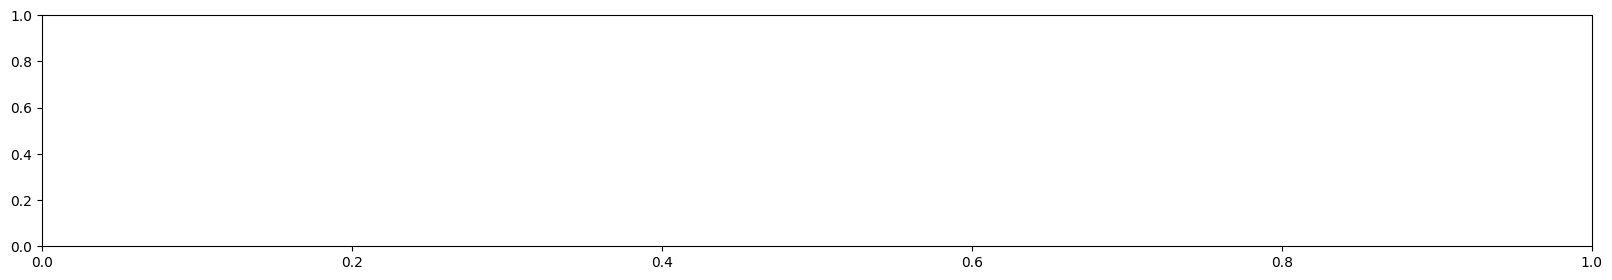

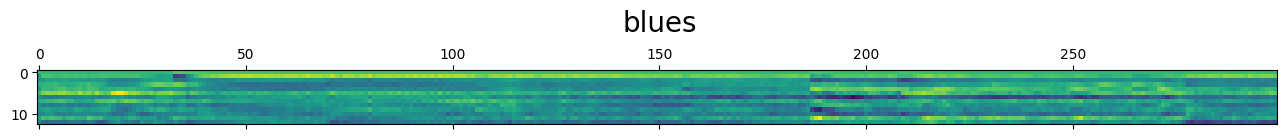

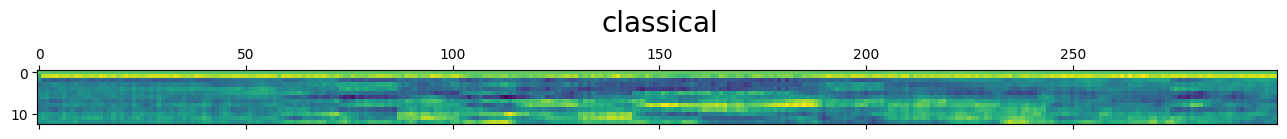

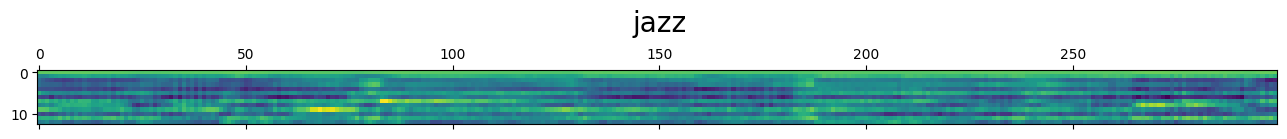

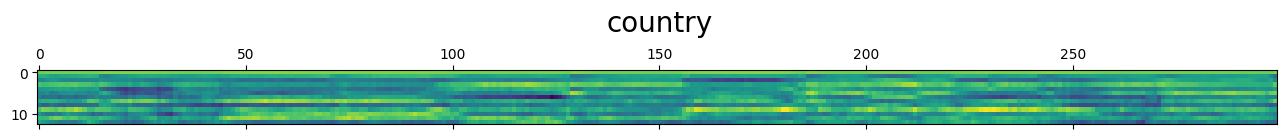

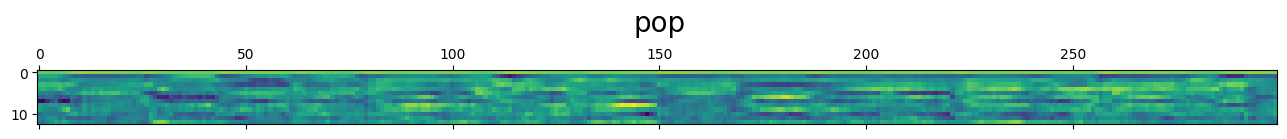

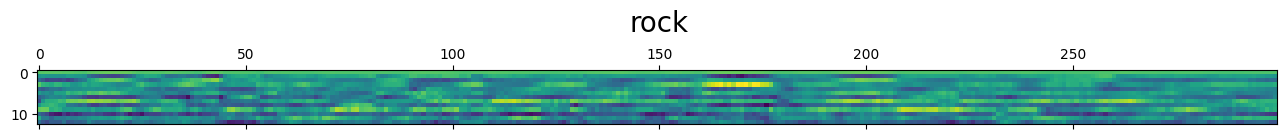

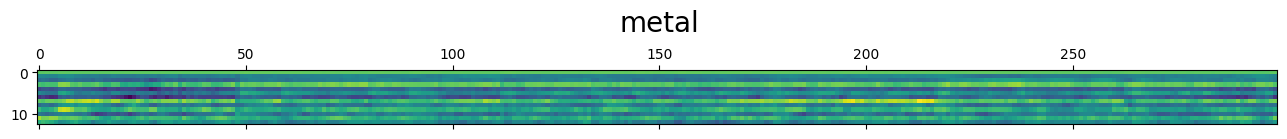

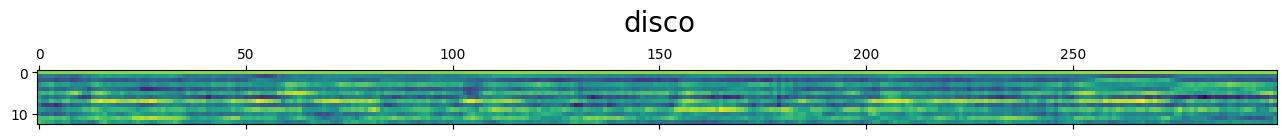

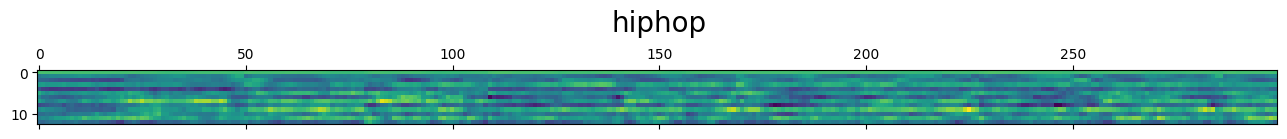

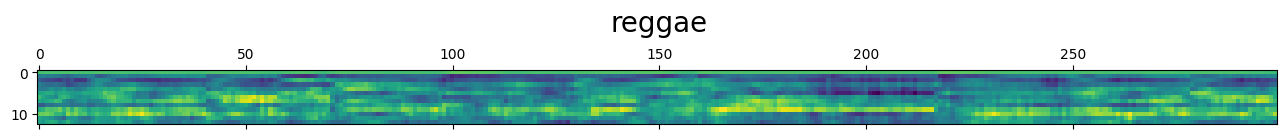

In [4]:
# libraries for previewing features for each genre
import glob
import os.path as path

# list all genres and initializes a feature
genre_list = ["blues","classical", "jazz", "country", "pop", "rock", "metal", "disco", "hiphop", "reggae"]
print(len(genre_list))

# for each genre, read the first .wav file, extract the MFCCs, plot the first 300 frames
figure = plt.figure(figsize=(20,3))
for idx ,genre in enumerate(genre_list): 
   example_data_path = 'genres/' + genre
   file_paths = glob.glob(path.join(example_data_path, '*.wav'))
   sampling_freq, audio = wavfile.read(file_paths[0])
   mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
   #print(mfcc_features)
   print(file_paths[0], mfcc_features.shape[0])
   plt.yscale('linear')
   plt.matshow((mfcc_features.T)[:,:300])
   plt.text(150, -10, genre, horizontalalignment='center', fontsize=20)
 
# display all the visualized MFCCs
plt.yscale('linear')
plt.show()

In [5]:
from python_speech_features import mfcc
from scipy.io import wavfile
import numpy as np
import os
import glob

# data preparation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# define your genres
genre_list = ["blues","classical", "jazz", "country", "pop", "rock", "metal", "disco", "hiphop", "reggae"]
data_dir = 'genres/'
X = []
y = []

# step 1: extract features
# fore each audio file, extract MFCC, average it across time, and store hte feature and genre label
for genre in genre_list:
    genre_path = os.path.join(data_dir, genre)
    file_paths = glob.glob(os.path.join(genre_path, "*.wav"))

    for file_path in file_paths:
        try:
            sampling_freq, audio = wavfile.read(file_path)
            features = mfcc(audio, sampling_freq, nfft=1024)
            
            # Step 2: aggregate features (e.g., mean across time axis)
            mean_features = np.mean(features, axis=0)
            
            X.append(mean_features)
            y.append(genre)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# step 3: train-test split
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Error reading genres/jazz/jazz.00054.wav: File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF', 'RIFX', and 'RF64' supported.


In [6]:
# hidden markov model class
class HMMTrainer(object):
  # initialize the HMM with given parameters
  def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=100):
    self.model_name = model_name
    self.n_components = n_components
    self.cov_type = cov_type
    self.n_iter = n_iter
    self.models = []
    if self.model_name == 'GaussianHMM':
      self.model = hmm.GaussianHMM(n_components=self.n_components,        covariance_type=self.cov_type,n_iter=self.n_iter)
    else:
      raise TypeError('Invalid model type') 

# functions to train the HMM and score new inputs
  def train(self, X):
    np.seterr(all='ignore')
    self.models.append(self.model.fit(X))
    # Run the model on input data
  def get_score(self, input_data):
    return self.model.score(input_data)

In [7]:
# initialize in order to train one model per genre
hmm_models = []
input_folder = 'genres/'

# parse the input directory
# for each genre, accumulate MFCCs for training, train a separate HMM
for dirname in os.listdir(input_folder):
    subfolder = os.path.join(input_folder, dirname)
    if not os.path.isdir(subfolder):
        continue

    label = subfolder[subfolder.rfind('/') + 1:]
    X = np.array([])
    y_words = []

    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-20]:
        filepath = os.path.join(subfolder, filename)
        try:
            # Try to read and process the audio file
            sampling_freq, audio = wavfile.read(filepath)
            mfcc_features = mfcc(audio, sampling_freq, nfft=1024)

            # Append features
            if len(X) == 0:
                X = mfcc_features
            else:
                X = np.append(X, mfcc_features, axis=0)

            y_words.append(label)

        except ValueError as e:
            print(f"Skipping file {filepath}: {e}")
        except Exception as e:
            print(f"Unexpected error with file {filepath}: {e}")

    if X.shape[0] > 0:
        print('X.shape =', X.shape)
        hmm_trainer = HMMTrainer(n_components=4)
        hmm_trainer.train(X)
        hmm_models.append((hmm_trainer, label))
        hmm_trainer = None
    else:
        print(f"No valid MFCC data found for label {label}, skipping training.")


X.shape = (239360, 13)
X.shape = (239424, 13)
X.shape = (239580, 13)
X.shape = (239520, 13)
X.shape = (239442, 13)
X.shape = (239655, 13)
X.shape = (239518, 13)
X.shape = (240115, 13)
X.shape = (239619, 13)
Skipping file genres/jazz/jazz.00054.wav: File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF', 'RIFX', and 'RF64' supported.
X.shape = (236717, 13)


In [8]:
# compare each test file against all trained HMMs
# pick the entre with the highest score

input_folder = 'genres/'
real_labels = []
pred_labels = []
for dirname in os.listdir(input_folder):

  subfolder = os.path.join(input_folder, dirname)
  if not os.path.isdir(subfolder):
    continue
  # Extract the label
  label_real = subfolder[subfolder.rfind('/') + 1:]

  for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][-20:]:
    real_labels.append(label_real)
    filepath = os.path.join(subfolder, filename)
    sampling_freq, audio = wavfile.read(filepath)
    mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
    max_score = -9999999999999999999
    output_label = None
    for item in hmm_models:
       hmm_model, label = item
       score = hmm_model.get_score(mfcc_features)
       if score > max_score:
          max_score = score
          output_label = label
    pred_labels.append(output_label)  # ← move this line here


In [9]:
# defines a function to plot the confusion matrix (normalized or raw)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.45 0.   0.   0.   0.   0.05 0.1  0.   0.   0.4 ]
 [0.   0.8  0.   0.05 0.   0.15 0.   0.   0.   0.  ]
 [0.1  0.   0.5  0.   0.   0.1  0.   0.05 0.   0.25]
 [0.1  0.   0.   0.2  0.05 0.   0.05 0.   0.05 0.55]
 [0.15 0.   0.   0.   0.35 0.   0.1  0.05 0.05 0.3 ]
 [0.2  0.05 0.   0.05 0.   0.6  0.   0.   0.   0.1 ]
 [0.   0.   0.2  0.05 0.   0.   0.7  0.   0.   0.05]
 [0.   0.   0.1  0.2  0.15 0.   0.   0.55 0.   0.  ]
 [0.   0.   0.   0.15 0.4  0.05 0.05 0.25 0.1  0.  ]
 [0.   0.   0.05 0.3  0.05 0.1  0.   0.   0.   0.5 ]]


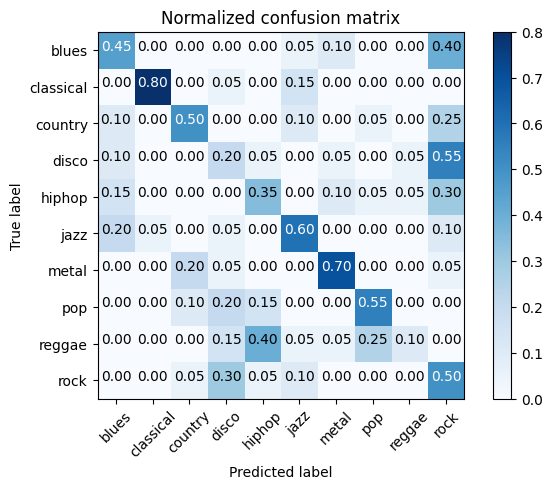

In [10]:
cm = confusion_matrix(real_labels, pred_labels)
np.set_printoptions(precision=2)
classes = ["blues","classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
plt.figure()
plot_confusion_matrix(cm, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

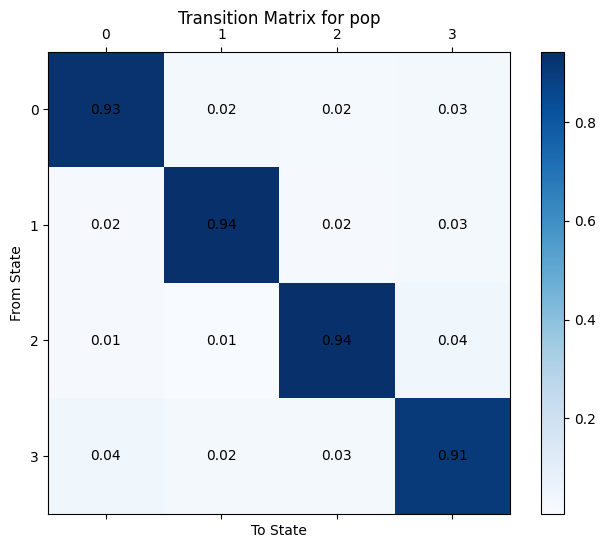

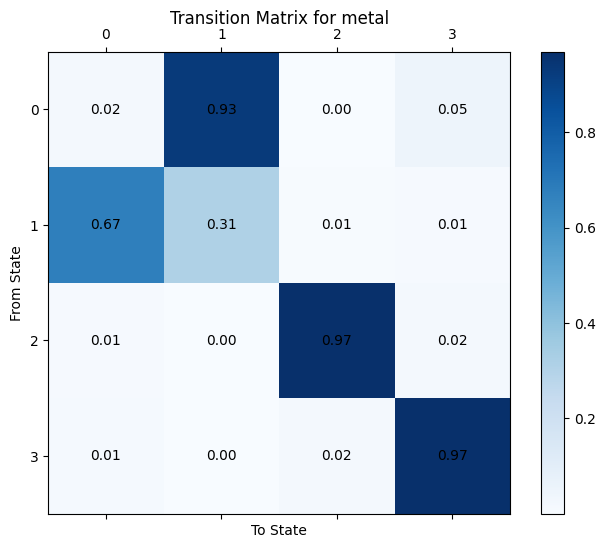

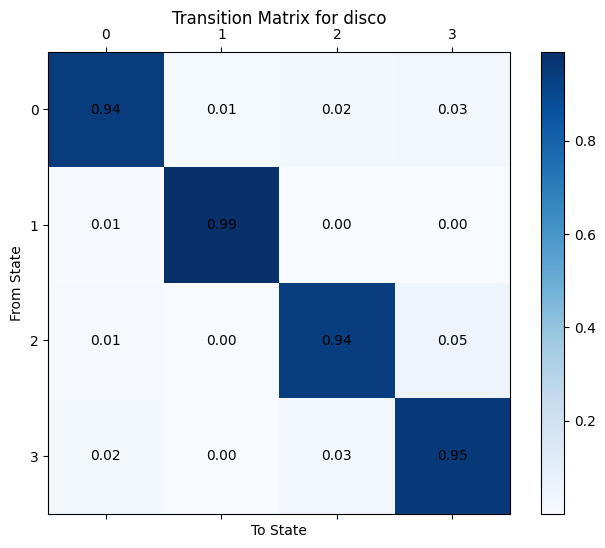

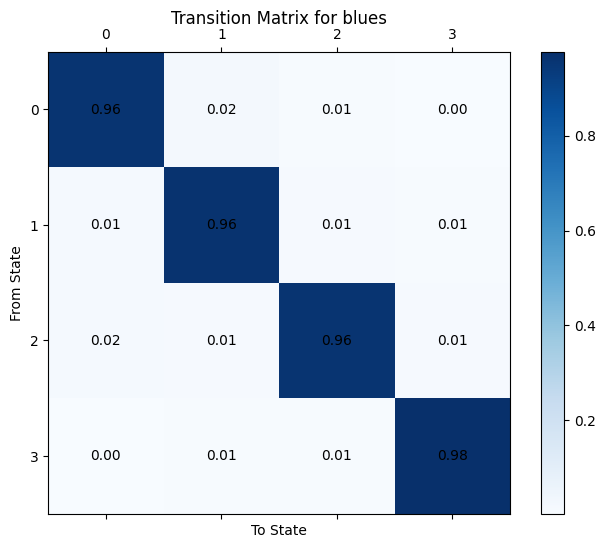

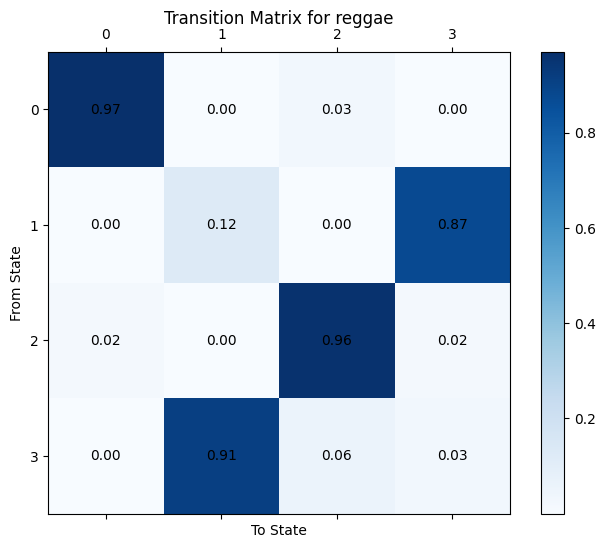

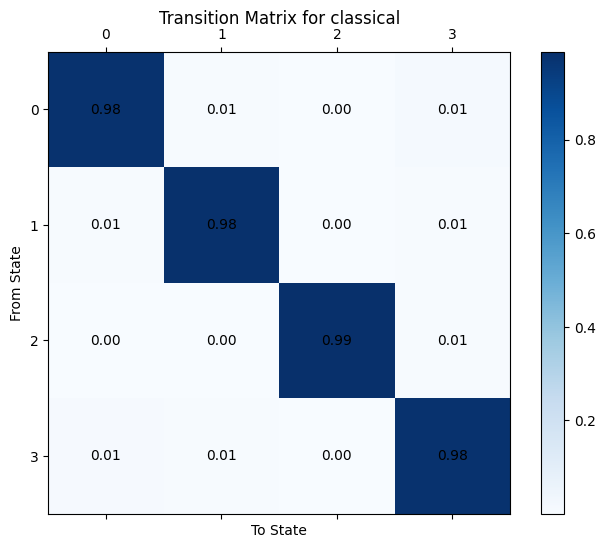

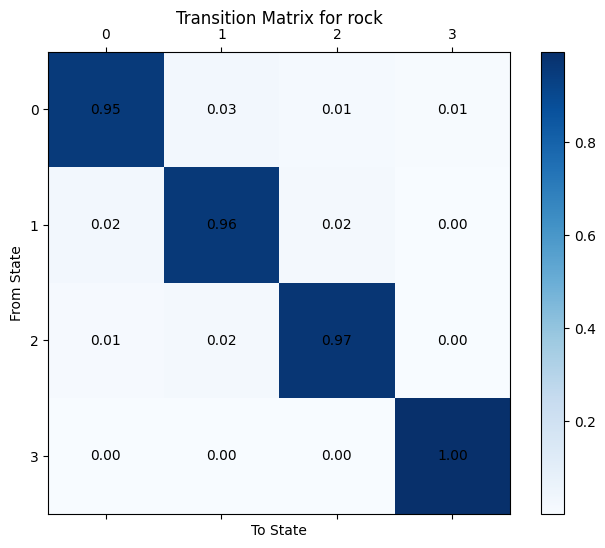

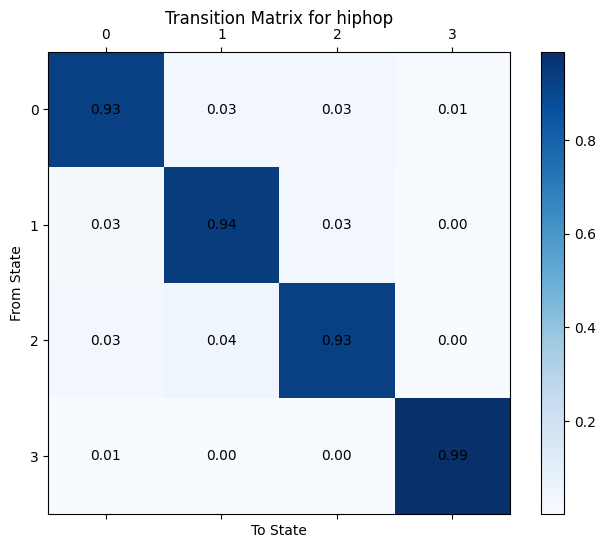

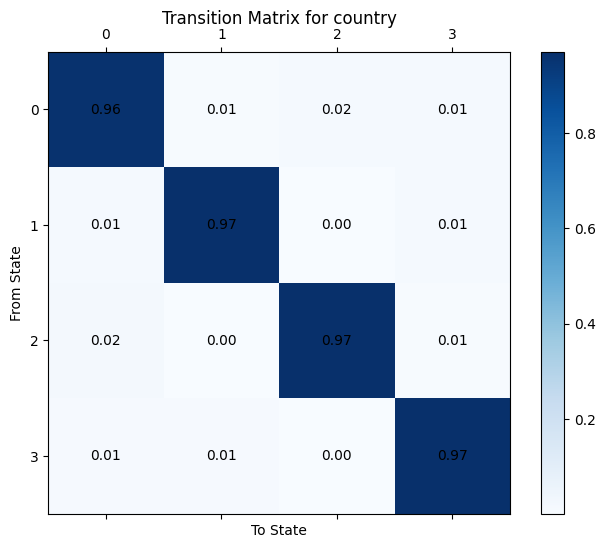

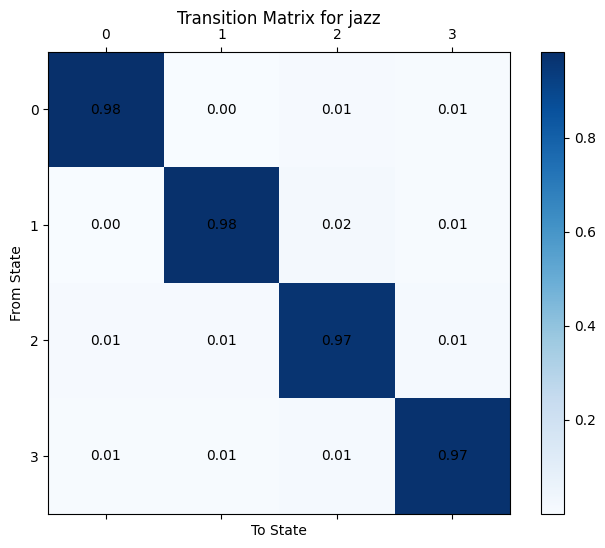

In [11]:
for hmm_model, label in hmm_models:
    matrix = hmm_model.model.transmat_  # access the underlying HMM
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(matrix, cmap='Blues')
    plt.title(f"Transition Matrix for {label}", pad=20)
    fig.colorbar(cax)

    ax.set_xlabel("To State")
    ax.set_ylabel("From State")
    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, f"{matrix[i, j]:.2f}", va='center', ha='center')

    plt.show()



In [12]:
# normalized confusion matrix; shows how well model classifies each genre
# normalized = all rows sum to 1, meaning it shows proportions, not raw counts



# classical was predicted very accurately; 89% of the classical tracks were classified as classical
from sklearn.metrics import classification_report
print("Performance Report for Hidden Markov Models")
print(classification_report(real_labels, pred_labels, target_names=classes))

Performance Report for Hidden Markov Models
              precision    recall  f1-score   support

       blues       0.45      0.45      0.45        20
   classical       0.94      0.80      0.86        20
     country       0.59      0.50      0.54        20
       disco       0.20      0.20      0.20        20
      hiphop       0.35      0.35      0.35        20
        jazz       0.57      0.60      0.59        20
       metal       0.70      0.70      0.70        20
         pop       0.61      0.55      0.58        20
      reggae       0.50      0.10      0.17        20
        rock       0.23      0.50      0.32        20

    accuracy                           0.47       200
   macro avg       0.51      0.47      0.48       200
weighted avg       0.51      0.47      0.48       200



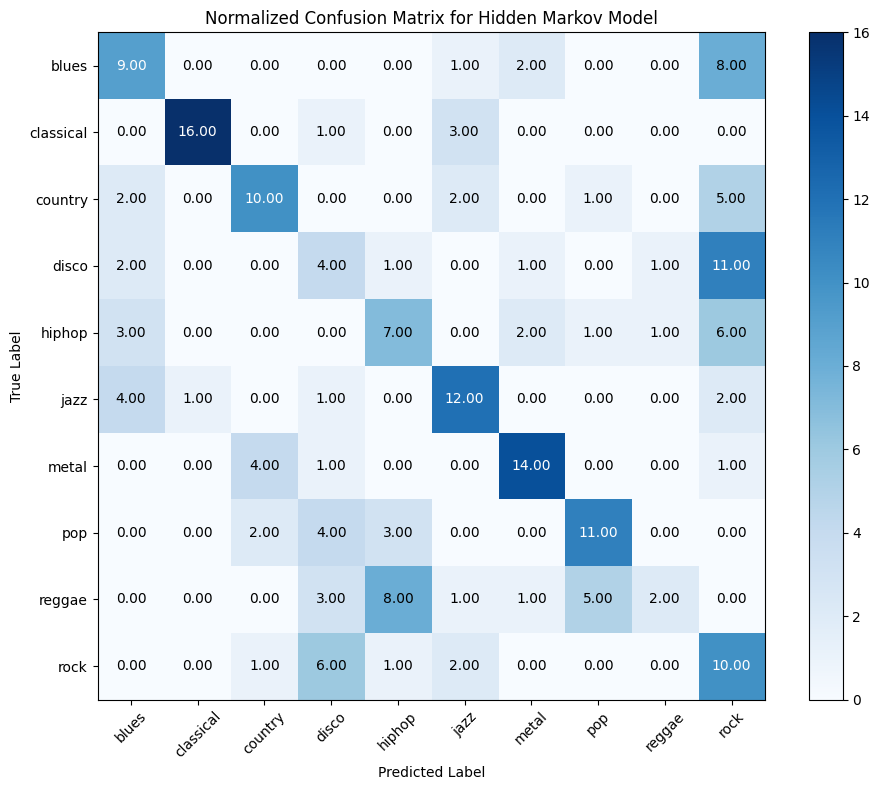

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# assuming cm is your confusion matrix (normalized), and classes is a list of class labels
# example:
# cm = np.array([[0.9, 0.1], [0.2, 0.8]])
# classes = ['Class A', 'Class B']

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Normalized Confusion Matrix for Hidden Markov Model')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Annotate each cell with the numeric value
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
